In [86]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [87]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [88]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [89]:
# create engine to hawaii.sqlite
database_path= "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [90]:
# reflect an existing database into a new model
base= automap_base()
base.prepare(engine, reflect=True)
# reflect the tables

In [91]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [92]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [93]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [94]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [95]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_dates = calc_temps('2014-03-22', '2014-03-30')
trip_dates

[(64.0, 71.79629629629629, 80.0)]

Text(0, 0.5, 'Temperature (F)')

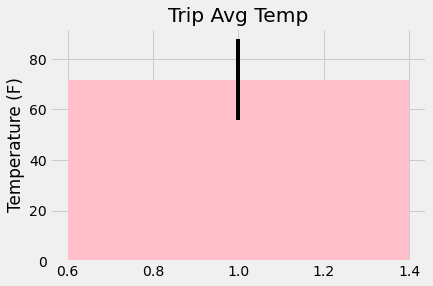

In [96]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

peak_t_peak = trip_dates[0][2] - trip_dates[0][0]
bar = plt.bar(1, trip_dates[0][1], yerr = peak_t_peak, color = "pink")
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
#plt.figsize(figsize=(20,3))


### Daily Rainfall Average

In [97]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.count(Measurement.prcp)).\
    filter(Measurement.date > '2013-03-22').filter(Measurement.date <= '2013-03-30').\
    group_by(Measurement.station, Station.name).order_by(func.count(Measurement.prcp).desc()).all()
total_rain

C:\Users\Owner\AppData\Local\Temp/ipykernel_4588/360385060.py:4: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  total_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.count(Measurement.prcp)).\


[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 8),
 ('USC00511918', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 8),
 ('USC00511918', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 8),
 ('USC00511918', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 8),
 ('USC00511918', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 8),
 ('USC00511918', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 8),
 ('USC00511918', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 8),
 ('USC00511918', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 8),
 ('USC00511918', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 8),
 ('USC00513117', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 8),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 8),
 ('USC00513117', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 8),
 ('USC00513117', 'MANOA LYON ARBO 785.2, HI US', 21.

In [98]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [99]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals= []
# Set the start and end date of the trip
start_date = '2014-03-22'
end_date = '2014-03-30'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, "%Y-%m-%d")
end = dt.datetime.strptime(end_date, "%Y-%m-%d")
date_generated = pd.date_range(start, end)
full_date = date_generated.strftime("%m-%d-%Y")
date_list = date_generated.strftime("%m-%d")

# Strip off the year and save a list of strings in the format %m-%d
date_list[0]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for date in date_list:
    normals.append(daily_normals(date))

normals[0][0]

tmin = []
tavg= []
tmax= []
for temps in normals:
    for temp in temps:
        tmin.append(temp[0])
        tavg.append(temp[1])
        tmax.append(temp[2])


tmin


[65.0, 63.0, 62.0, 63.0, 64.0, 63.0, 59.0, 58.0, 62.0]

In [100]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
values= {'Trip Dates': full_date, 'TMin':tmin, 'TMax': tmax, 'Tavg':tavg}
trip_df= pd.DataFrame(values)
trip_df.set_index('Trip Dates')

,TMin,TMax,Tavg
Trip Dates,,,
03-22-2014,65.0,77.0,71.754717
03-23-2014,63.0,78.0,70.796296
03-24-2014,62.0,77.0,71.500000
03-25-2014,63.0,78.0,71.500000
03-26-2014,64.0,80.0,71.380000
03-27-2014,63.0,80.0,71.538462
03-28-2014,59.0,82.0,71.517857
03-29-2014,58.0,77.0,71.357143
03-30-2014,62.0,79.0,72.175439


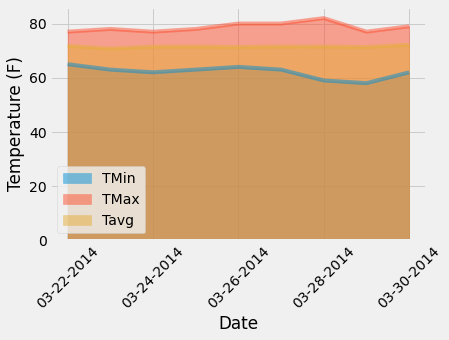

In [101]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_df.plot.area(x='Trip Dates', stacked=False)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.xticks(rotation=45);

## Close Session

In [102]:
session.close

<bound method Session.close of <sqlalchemy.orm.session.Session object at 0x00000289B0DE8670>>